In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

## <span id="top">Modelling</span>

1. [Detailed vs. Simplified Lightcurve](#m_diff)
2. [Hardness Ratio for LAT/GBM](#hard)
3. [Expected T90](#t90)
4. [Expected Anisotropy Ratio](#aniso)

We have so far modelled the simplified lightcurve in the Fitting notebook as follows:

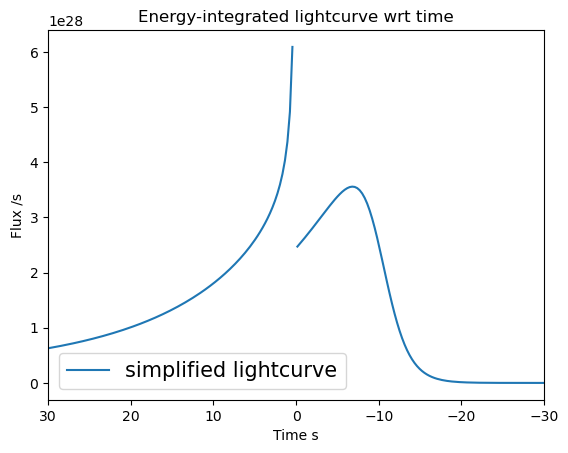

In [2]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV

# lifetime only, no spectrum.
# Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
afterglow = lambda tau, delta, t_m, t_p, normalization: (
    normalization * np.exp(-(1/t_p)*(tau-delta))/(1 + np.exp(-(1/t_m)*(tau-delta))))

# Simplifying lightcurve with powerlaw of index -.52
lightcurve = lambda tau, energy_range, normalization = 1., index = .52: normalization*tau**(-index)

tau_s = np.linspace(30,0,100)
tau_a = np.linspace(30,-30,200)

s_curve = np.zeros(200)

fig, ax = plt.subplots()

s_curve[0:100] = lightcurve(tau_s,energy_range = np.linspace(Emin, Emax, 1000), normalization = 2*1e28)

a_curve = afterglow(tau_a, -10, 1.5, 14, 5*1e28)

ax.plot(tau_a, s_curve + a_curve, label = 'simplified lightcurve')

ax.set_xlim(30,-30)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

Let's try to replicate the above using the more complex models.

Paper: [BH evaporation models](https://arxiv.org/pdf/1510.04372.pdf)
- 3.3: Photon spectrum
- 3.4: Time-integrated photon spectrum
- 3.5: Light curve

[LAT and GBM detector energy ranges](https://hesperia.gsfc.nasa.gov/fermi_solar/summary_gbm_lat.htm):
- LAT: 20 MeV to 300 GeV
- Twelve GBM NaI: 8 keV to 1 MeV
- Two GBM BGO: 200 keV to 40 MeV

In [3]:
import scipy.integrate as I

#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV


theta_s = lambda x: 0.5 * (1+ np.tanh(10*x))

class EBH:
    
    def __init__(self):
        self.A = 6.339 * 10**23 # /GeV/s
        self.B = 1.1367 * 10**24
        self.c1 = 1.13*10**19
        self.c2 = .0962
        self.c3 = 1.908
        self.c4 = 1.982
        self.x_c = 1.287 * 10**(-4)
        return
        
    def fluxdtdE_frag(self, x):
        return ( 
                ( self.A * x**(-3/2) ) * ( 1 - theta_s(x - .3) ) + 
                self.B * np.exp(-x) * 1/(x*x + x) * theta_s(x - 3)
                )
    
    def fluxdtdE_direct(self, x):
        c = self.c1 * x**6 / np.expm1(x)

        f = np.exp(-self.c2 
                - self.c4*(np.log(x) - self.c3)*
                (1+np.tanh(20* (np.log(x) - self.c3) ) ))
        f[np.where(f == 2)] = 1.
        return f
    
    def x(self, E, # Unitless energy /GeV
          tau, # Unitless remaining liftime /s
          mass = None): # Mass remaining in kg
        
        if tau is not None:
            f = lambda E, t: self.x_c * (E) * t**(1/3)
            tick = tau
        elif mass is not None:
            # x = E/kT
            # kT = 1.058 * 10e10kg / M_BH GeV
            # x = E * M_BH /  (1.058 * 10e10kg)
            f = lambda E, m: E*m/(1.058 * 10e10)
            tick = mass
        else:
            raise Exception('Provide a tau or mass.')
        
        
        if isinstance(tick, np.ndarray):
            # If we give a n-dim E and a m-dim tau
            # We want back a n x m array of x
            x = []
            for i in tick:
                x.append(f(E,i))
            return np.array(x)
        else:
            return f(E,tick)
    
    def convert_ticks(self, tau=None, mass=None):
        # x = E*M_BH / 1.058*10e10kg
        # x = x_c*E*t^1/3
        if tau is None:
            # t = [ M_BH / (x_c * 1.058*10e10) ]**3
            return ( mass / (self.x_c * 1.058 * 10e10) )**3
        elif mass is None:
            # M_BH = x_c*t^1/3 * 1.058*10e10
            return self.x_c * tau**(1/3) * 1.058*10e10
        else:
            raise Exception('Provide a tau or mass.')
    
    def spectrum(self, E, tau, both=True, x=None):

        if x is None:
            x = self.x(E, tau)
        if both == 'primary':
            return self.fluxdtdE_direct(x)
        elif both == 'secondary': 
            return self.fluxdtdE_frag(x)
        else: 
            return self.fluxdtdE_frag(x) + self.fluxdtdE_direct(x)
        
    def lightcurve(self, energy_range, tau):
        c = np.zeros(len(tau))
        for i,t in enumerate(tau):
            c[i] = I.trapz(self.spectrum(energy_range, t))
        return c

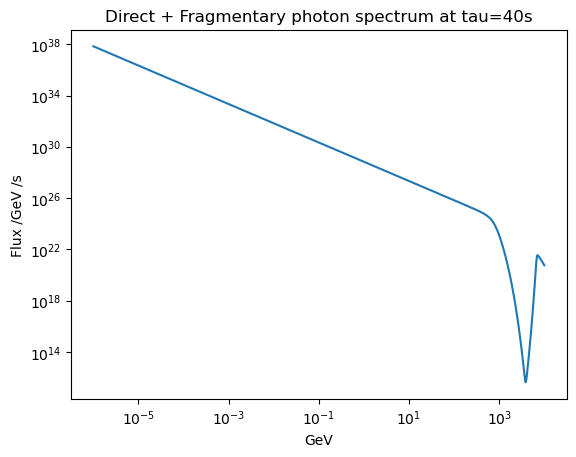

In [74]:
fig, ax = plt.subplots()

p_s = EBH()
energy_range = np.linspace(10**(-6), 10**4, 100)

ax.loglog(energy_range, p_s.spectrum(energy_range, 40))

ax.set_ylabel('Flux /GeV /s')
ax.set_xlabel('GeV')
ax.set_title('Direct + Fragmentary photon spectrum at tau=40s')
plt.show()

### <span id='m_diff'>Detailed vs. Simplified Lightcurve</span>
[To Top](#top)

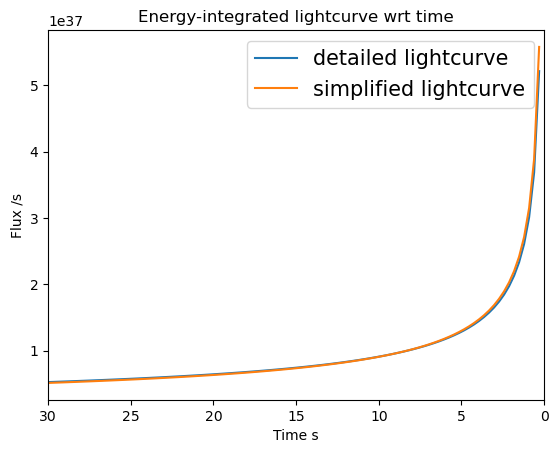

In [5]:
tau = np.linspace(30,0,100) 

fig, ax = plt.subplots()

# Thank goodness I finally fixed this!!!
ax.plot(tau, 
        EBH().lightcurve(np.linspace(Emin, Emax, 100), np.linspace(30,0,100)),
        label = 'detailed lightcurve')

ax.plot(tau, 
        lightcurve(tau,energy_range = np.linspace(Emin, Emax, 1000), normalization = 3e37),
        label = 'simplified lightcurve')

ax.set_xlim(30,0)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

''

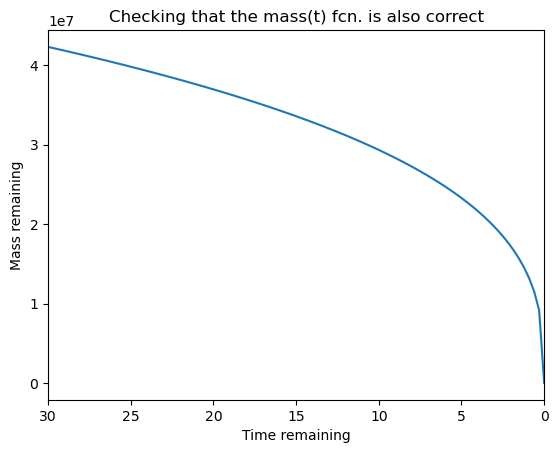

In [14]:
plt.plot(tau, mass)
plt.xlim(30,0)
plt.xlabel('Time remaining')
plt.ylabel('Mass remaining')
plt.title('Checking that the mass(t) fcn. is also correct')
''

### <span id='hard'>Hardness Ratio for LAT/GBM</span>
[To Top](#top)

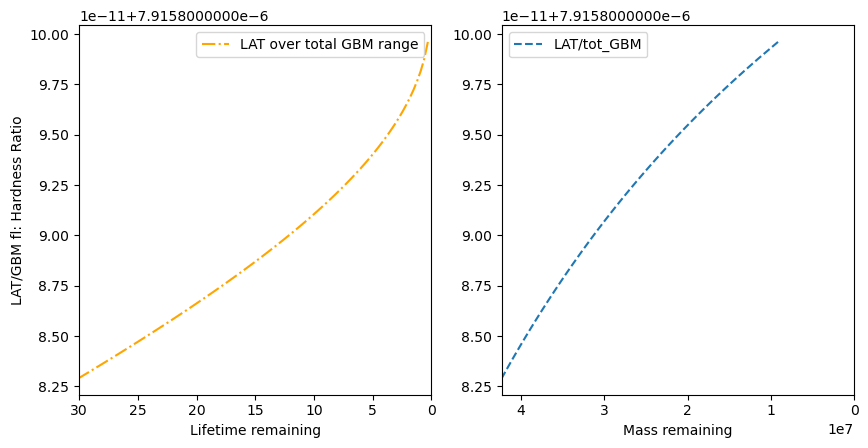

In [11]:
LAT_e =     (20e-3 , 300) #20MeV to 300GeV
GBM_BGO_e = (200e-6, 40e-3) #200keV to 40MeV
GBM_NaI_e = (8e-6  , 1e-3) # 8keV to 1MeV

fig, ax = plt.subplots(1,2)

tau = np.linspace(0,30,100)

LAT_curve = EBH().lightcurve(
    np.linspace(LAT_e[0], LAT_e[1], 100), tau)

GBM_BGO_curve = EBH().lightcurve(
    np.linspace(GBM_BGO_e[0], GBM_BGO_e[1], 100), tau)

GBM_NaI_curve = EBH().lightcurve(
    np.linspace(GBM_NaI_e[0], GBM_NaI_e[1], 100), tau)

GBM_total_curve = EBH().lightcurve(
    np.linspace(GBM_NaI_e[0], GBM_BGO_e[1], 100), tau)

ax[0].plot(tau, LAT_curve/GBM_total_curve, '-.', label='LAT over total GBM range', color = 'orange')
#ax[0].plot(tau, LAT_curve/GBM_BGO_curve, '-.', label='... over GBM BGO', color='blue')
#ax[0].plot(tau, LAT_curve/GBM_NaI_curve, '-.', label='... over GBM NaI', color='green')
ax[0].set_xlim(30,0)
ax[0].legend()
ax[0].set_xlabel('Lifetime remaining')
ax[0].set_ylabel('LAT/GBM fl: Hardness Ratio')

mass = EBH().convert_ticks(tau=tau)
ax[1].plot(mass, LAT_curve/GBM_total_curve, '--', label = 'LAT/tot_GBM')
ax[1].set_xlim(mass.max(), mass.min())
ax[1].set_xlabel('Mass remaining')
ax[1].legend()

fig.set_figwidth(10)
fig.show()

### <span id='t90'>Expected T90</span>
[To Top](#top)

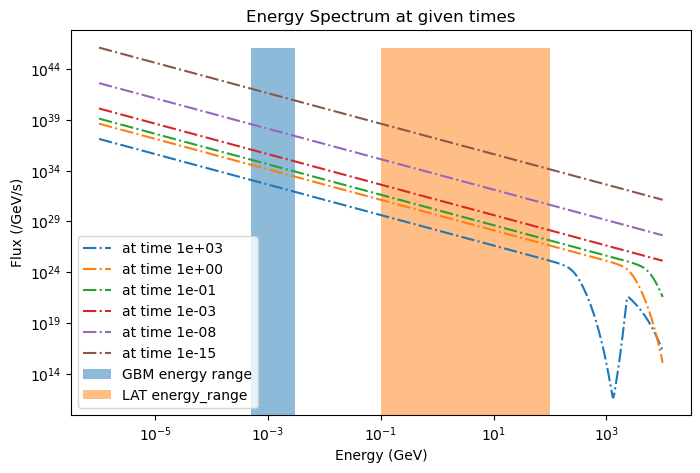

In [92]:
# Our energy ranges are:
GBM_e = (50*10e-6, 300*10e-6)
LAT_e = (0.1, 100)

# Let's show what that looks like!

fig, ax = plt.subplots()

ax.set_title('Energy Spectrum at given times')

mx = 0
for time in [1e3,1,1e-1,1e-3,1e-8,1e-15]:
    energy_linspace = np.linspace(10**(-6), 10**4, 1000)
    full_lc = EBH().spectrum(energy_linspace, time)
    ax.loglog(energy_linspace, full_lc, '-.', label='at time %.e'%time)
    if full_lc.max()>mx:
        mx = full_lc.max()

# GBM only
energy_linspace = np.linspace(GBM_e[0], GBM_e[1], 100)
#GBM_lc = EBH().spectrum(energy_linspace, 1e-3)
ax.fill_between(energy_linspace, 0, mx, alpha=0.5, label = 'GBM energy range')

# LAT only
energy_linspace = np.linspace(LAT_e[0], LAT_e[1], 100)
#LAT_lc = EBH().spectrum(energy_linspace, 1e-3)
ax.fill_between(energy_linspace, 0, mx, alpha=0.5, label = 'LAT energy_range')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (/GeV/s)')

ax.legend()
fig.set_figwidth(8)
fig.set_figheight(5)

LAT intersect at energy 2.47e+31, time 0.10
GBM intersect at energy 3.07e+37, time 0.10


(0.5, 0.0)

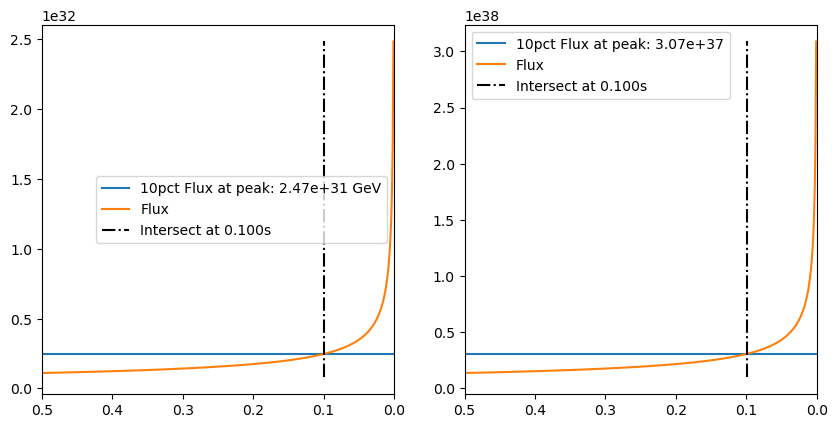

In [49]:
alphaSM = 8.3* 1e17
M0 = 1e7

tau = lambda M0: M0**3/(3 * alphaSM)

# mass as a function of time to explosion
SMMass = lambda time: (M0**3 - 3 * alphaSM * (tau(M0) - time))**(1/3)

tau = EBH().convert_ticks( mass = SMMass(np.linspace(1e3,0,1000,endpoint=False)) )

#mass = np.linspace(1e7,0,1000, endpoint=False)
#tau = np.linspace(0,.5,1000, endpoint=False)#EBH().convert_ticks(mass)

"""
Seems like the strategy here is to generate a numner where 0.1 max fluence is passed.
From there, we can assume the rest of the time to peak is the signal duration.
"""

_ = EBH().lightcurve(np.linspace(LAT_e[0], LAT_e[1], 100), [1e-3])[0]

LAT_F = (0.1*_, 0.9*_)

_ = EBH().lightcurve(np.linspace(GBM_NaI_e[0], GBM_BGO_e[1], 100), [1e-3])[0]

GBM_F = (0.1*_, 0.9*_)

#print(LAT_F)
#print(GBM_F)


fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)


#### LAT

# 10% of the flux at peak emission. This corresponds to the lower-bound for T90 to begin.
ax[0].plot(tau, 
           np.ones(1000)*LAT_F[0], 
           label = '10pct Flux at peak: %.2e GeV'%LAT_F[0])

# Generate lightcurve
lc_LAT = EBH().lightcurve(np.linspace(LAT_e[0], LAT_e[1], 100), tau)
ax[0].plot(tau, lc_LAT, label = 'Flux')

# Find the intersection between Lightcurve and the 10% peak flux
intersect = np.where(lc_LAT > LAT_F[0])[0][0]
ax[0].plot(np.ones(2)*tau[intersect], [lc_LAT.min(), lc_LAT.max()], '-.', color='black',
           label = 'Intersect at %.3fs'%tau[intersect])

print('LAT intersect at energy %.2e, time %.2f'%(lc_LAT[intersect], tau[intersect]))

ax[0].legend()
ax[0].set_xlim(.5,0)


#### GBM
ax[1].plot(tau, 
           np.ones(1000)*GBM_F[0], 
           label = '10pct Flux at peak: %.2e'%GBM_F[0])

lc_GBM = EBH().lightcurve(np.linspace(GBM_NaI_e[0], GBM_BGO_e[1], 100), tau)
ax[1].plot(tau, lc_GBM, label = 'Flux')

intersect = np.where(lc_GBM > GBM_F[0])[0][0]
ax[1].plot(np.ones(2)*tau[intersect], [lc_GBM.min(), lc_GBM.max()], '-.', color='black',
           label = 'Intersect at %.3fs'%tau[intersect])

print('GBM intersect at energy %.2e, time %.2f'%(lc_GBM[intersect], tau[intersect]))

ax[1].legend()
ax[1].set_xlim(.5,0)

In [52]:
px.line(pd.DataFrame({'tau':tau, 'lc':lc_LAT, '10pct':np.ones(1000)*LAT_F[0]}), x='tau', y=['lc', '10pct'])

In [51]:
px.line(pd.DataFrame({'tau':tau, 'lc':lc_GBM, '10pct':np.ones(1000)*GBM_F[0]}), x='tau', y=['lc', '10pct'])

### <span id='aniso'>Expected Anisotropy Ratio</span>
[To Top](#top)